<a href="https://colab.research.google.com/github/bksat90/FinalProject/blob/main/classification_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# necessary imports
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import pathlib
import PIL
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image, ImageFilter

In [3]:
# mounting gdrive.
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# # Unzip the images. (one time activity)
# !unzip "/content/drive/MyDrive/Project_BC/archive.zip" -d "/content/drive/MyDrive/Project_BC/cnn/"

# **Exploratory Data Analysis**

In [40]:
# find the data counts for training data
path = "/content/drive/MyDrive/Project_BC/cnn/train/"
tr_benign = len(os.listdir(path + "/0"))
tr_malignant = len(os.listdir(path + "/1"))
print('Number of benign images:' , tr_benign)
print('Number of malignant images:' , tr_malignant)

Number of benign images: 1569
Number of malignant images: 803


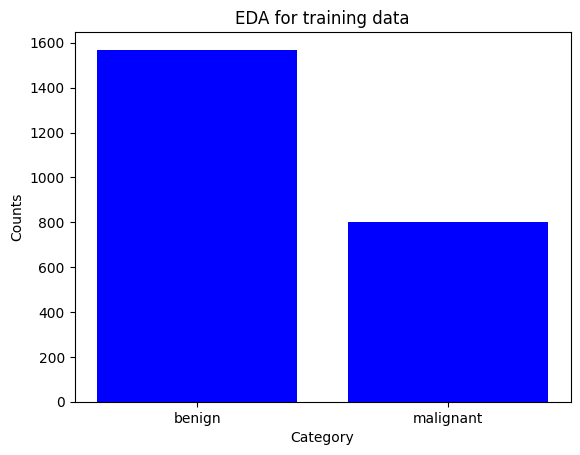

In [41]:
# depict the data into graph for training data
labels = ['benign', 'malignant']
counts = [tr_benign, tr_malignant]

plt.bar(labels, counts, color ='blue')
plt.xlabel('Category')
plt.ylabel('Counts')
plt.title('EDA for training data')
plt.show()

In [42]:
# find the data counts for test data
path = "/content/drive/MyDrive/Project_BC/cnn/test/"
tt_benign = len(os.listdir(path + "/0"))
tt_malignant = len(os.listdir(path + "/1"))
print('Number of benign images:', tt_benign)
print('Number of malignant images:', tt_malignant)

Number of benign images: 208
Number of malignant images: 128


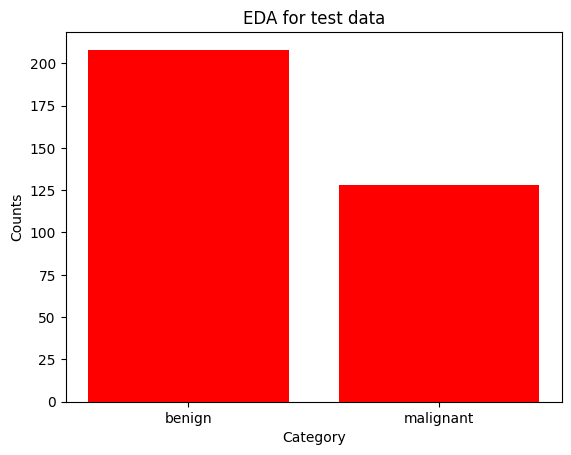

In [43]:
# depict the data into graph for test data
test_labels = ['benign', 'malignant']
test_counts = [tt_benign, tt_malignant]

plt.bar(test_labels, test_counts, color ='red')
plt.xlabel('Category')
plt.ylabel('Counts')
plt.title('EDA for test data')
plt.show()

# **Data Preprocessing**

In [9]:
# define median filter function
def median_filter(sourcepath, targetpath):
  for filename in os.listdir(sourcepath):
    pic = Image.open(sourcepath + filename)
    pic = pic.filter(ImageFilter.MedianFilter(size=3))
    pic.save(targetpath + filename)

In [14]:
def call_filter(srcpath, trgpath):
  # apply the filter for the benign images
  sourcepath = srcpath + "0/"
  targetpath = trgpath + "0/"
  median_filter(sourcepath, targetpath)

  # apply the filter for the malignant images
  sourcepath = srcpath + "1/"
  targetpath = trgpath + "1/"
  median_filter(sourcepath, targetpath)

In [15]:
# apply the filter for the training images
srcpath = "/content/drive/MyDrive/Project_BC/cnn/train/"
trgpath = "/content/drive/MyDrive/Project_BC/median/train/"
call_filter(srcpath, trgpath)

In [16]:
# apply the filter for the test images
srcpath = "/content/drive/MyDrive/Project_BC/cnn/test/"
trgpath = "/content/drive/MyDrive/Project_BC/median/test/"
call_filter(srcpath, trgpath)

In [ ]:
# copy the image
def copy(sourcepath, targetpath):
  for filename in os.listdir(sourcepath):
    pic = Image.open(sourcepath + filename)
    pic.save(targetpath + filename)

In [20]:
# apply vertical flip
def flip_vertical(sourcepath, targetpath):
  for filename in os.listdir(sourcepath):
    pic = Image.open(sourcepath + filename)
    pic = pic.transpose(Image.FLIP_TOP_BOTTOM)
    pic.save(targetpath + 'vert' + filename)

In [21]:
# apply horizontal flip
def flip_horizontal(sourcepath, targetpath):
  for filename in os.listdir(sourcepath):
    pic = Image.open(sourcepath + filename)
    pic = pic.transpose(Image.FLIP_LEFT_RIGHT)
    pic.save(targetpath + 'horiz' + filename)

In [35]:
def call_flip(srcpath, trgpath):
  # apply the flip for the benign images
  sourcepath = srcpath + "0/"
  targetpath = trgpath + "0/"
  copy(sourcepath, targetpath)
  flip_vertical(sourcepath, targetpath)
  flip_horizontal(sourcepath, targetpath)

  # apply the flip for the malignant images
  sourcepath = srcpath + "1/"
  targetpath = trgpath + "1/"
  copy(sourcepath, targetpath)
  flip_vertical(sourcepath, targetpath)
  flip_horizontal(sourcepath, targetpath)

In [23]:
# apply the flips for the training images
srcpath = "/content/drive/MyDrive/Project_BC/median/train/"
trgpath = "/content/drive/MyDrive/Project_BC/flip/train/"
call_flip(srcpath, trgpath)

In [25]:
# apply the flips for the test images
srcpath = "/content/drive/MyDrive/Project_BC/median/test/"
trgpath = "/content/drive/MyDrive/Project_BC/flip/test/"
call_flip(srcpath, trgpath)

In [46]:
# label_diction = {'benign' : 0, 'malignant' : 1}

def process_image(filename):
  pieces = tf.strings.split(filename, '/')
  label = pieces[-2]
  label = tf.strings.to_number(label)
  picture = tf.io.read_file(filename)
  picture = tf.io.decode_jpeg(picture)
  return picture, label

In [ ]:
# resize the images
def resize(picture, label):
    picture = tf.image.resize(tf.cast(picture, tf.float32),
                            size=[240,240]) /255.0
    return picture, label

In [48]:
# prepare the dataset list of the input files
loc = "/content/drive/MyDrive/Project_BC/flip/"

train_data = tf.data.Dataset.list_files(loc + "train/*/*")
test_data = tf.data.Dataset.list_files(loc + "test/*/*")

In [49]:
# processing the training data
train_data = train_data.shuffle(1000)
train_data = train_data.map(process_image)
train_data = train_data.map(resize)
train_data = train_data.batch(128)

# processing the test data
test_data = test_data.shuffle(1000)
test_data = test_data.map(process_image)
test_data = test_data.map(resize)
test_data = test_data.batch(128)

Model 1:

In [59]:
input_layer = layers.Input(shape=(240, 240, 3), name='Input')

conv0 = layers.Conv2D(16, (5, 5), activation='relu', padding="same",
                      strides=(2, 2), name='Conv0')(input_layer)
conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding="same",
                      strides=(1, 1), name='Conv1')(conv0)
conv2 = layers.Conv2D(32, (3, 3), activation='relu', padding="same",
                      strides=(1, 1), name='Conv2')(conv1)
pool1 = layers.MaxPooling2D((2, 2), name='Pool1')(conv2)

batch1 = layers.BatchNormalization(name='Batch1')(pool1)

drop1 = layers.Dropout(0.2, name='Drop1')(batch1)

global_pool = layers.GlobalAveragePooling2D(name='GlobalPool')(drop1)

fc1 = layers.Dense(240, activation='relu', name='FC1')(global_pool)

output_layer = layers.Dense(1, activation='sigmoid', name='Output')(fc1)

# create the model
mod1 = models.Model(inputs=input_layer, outputs=output_layer)

Model 2


In [63]:

conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding="same",
                      strides=(1, 1), name='Conv3')(drop1)
conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding="same",
                      strides=(1, 1), name='Conv4')(conv3)
pool2 = layers.MaxPooling2D((2, 2), name='Pool2')(conv4)

batch2 = layers.BatchNormalization(name='Batch2')(pool2)

drop2 = layers.Dropout(0.2, name='Drop2')(batch2)

global_pool = layers.GlobalAveragePooling2D(name='GlobalPool')(drop2)


fc1 = layers.Dense(240, activation='relu', name='FC1')(global_pool)


output_layer = layers.Dense(1, activation='sigmoid', name='Output')(fc1)

# create the model 2
mod2 = models.Model(inputs=input_layer, outputs=output_layer)

In [64]:
mod1.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv0 (Conv2D)                       │ (None, 120, 120, 16)        │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1 (Conv2D)                       │ (None, 120, 120, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 120, 120, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool1 (MaxPooling2D)                 │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Batch1 (BatchNormalization)          │ (None, 60, 60, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop1 (Dropout)                      │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3 (Conv2D)                       │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv4 (Conv2D)                       │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool2 (MaxPooling2D)                 │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv5 (Conv2D)                       │ (None, 30, 30, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv6 (Conv2D)                       │ (None, 30, 30, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GlobalPool (GlobalAveragePooling2D)  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC1 (Dense)                          │ (None, 240)                 │          30,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 1)                   │             241 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,297 (1.23 MB)

 Trainable params: 323,233 (1.23 MB)

 Non-trainable params: 64 (256.00 B)

In [65]:
mod2.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv0 (Conv2D)                       │ (None, 120, 120, 16)        │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1 (Conv2D)                       │ (None, 120, 120, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 120, 120, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool1 (MaxPooling2D)                 │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Batch1 (BatchNormalization)          │ (None, 60, 60, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop1 (Dropout)                      │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3 (Conv2D)                       │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv4 (Conv2D)                       │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool2 (MaxPooling2D)                 │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Batch2 (BatchNormalization)          │ (None, 30, 30, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop2 (Dropout)                      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GlobalPool (GlobalAveragePooling2D)  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC1 (Dense)                          │ (None, 240)                 │          15,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 1)                   │             241 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 86,753 (338.88 KB)

 Trainable params: 86,561 (338.13 KB)

 Non-trainable params: 192 (768.00 B)

In [66]:
mod1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [68]:
epoch_num = 50

history = mod1.fit(train_data, validation_data=test_data, epochs=epoch_num)

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 50s 773ms/step - accuracy: 0.5850 - loss: 0.6669 - val_accuracy: 0.6190 - val_loss: 0.6849
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 701ms/step - accuracy: 0.6541 - loss: 0.6426 - val_accuracy: 0.6190 - val_loss: 0.6815
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 36s 617ms/step - accuracy: 0.6690 - loss: 0.6300 - val_accuracy: 0.6190 - val_loss: 0.6792
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 727ms/step - accuracy: 0.6604 - loss: 0.6344 - val_accuracy: 0.6190 - val_loss: 0.6760
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 36s 643ms/step - accuracy: 0.6604 - loss: 0.6324 - val_accuracy: 0.6190 - val_loss: 0.6739
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 598ms/step - accuracy: 0.6576 - loss: 0.6360 - val_accuracy: 0.6190 - val_loss: 0.6690
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 606ms/step - accuracy: 0.6528 - loss: 0.6367 - val_accuracy: 0.6190 - val_loss: 0.6635
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 652ms/step - accuracy: 0.6632 - loss: 0.6271 - val_accu

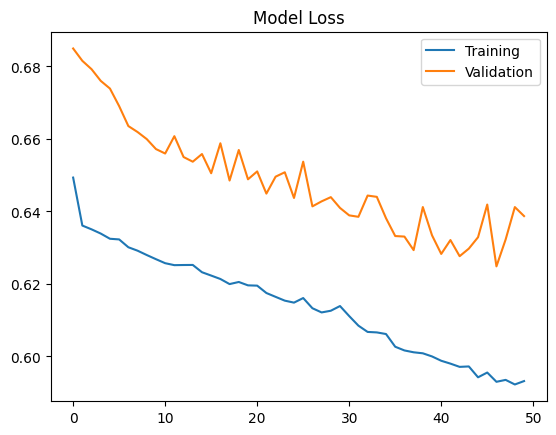

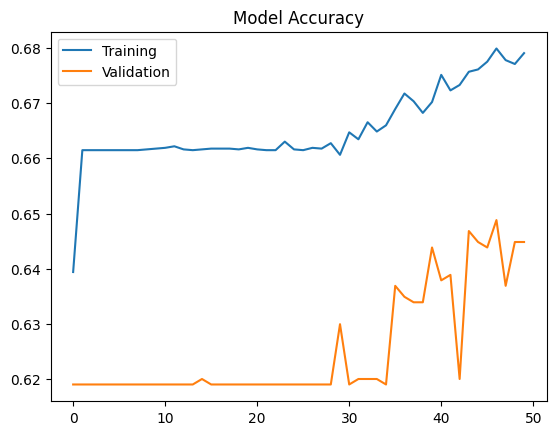

In [69]:
plt.figure()
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.title('Model Loss')

plt.figure()
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.title('Model Accuracy')

plt.show()

In [70]:
mod2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [71]:
epoch_num = 50

history = mod2.fit(train_data, validation_data=test_data, epochs=epoch_num)

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 58s 901ms/step - accuracy: 0.6066 - loss: 0.6636 - val_accuracy: 0.6190 - val_loss: 0.6855
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 42s 756ms/step - accuracy: 0.6557 - loss: 0.6497 - val_accuracy: 0.6190 - val_loss: 0.6725
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 593ms/step - accuracy: 0.6619 - loss: 0.6366 - val_accuracy: 0.6190 - val_loss: 0.6662
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 52s 799ms/step - accuracy: 0.6606 - loss: 0.6308 - val_accuracy: 0.6190 - val_loss: 0.6682
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 35s 628ms/step - accuracy: 0.6637 - loss: 0.6286 - val_accuracy: 0.6190 - val_loss: 0.6740
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 36s 641ms/step - accuracy: 0.6610 - loss: 0.6251 - val_accuracy: 0.6190 - val_loss: 0.6794
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 629ms/step - accuracy: 0.6514 - loss: 0.6295 - val_accuracy: 0.6190 - val_loss: 0.6782
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 42s 657ms/step - accuracy: 0.6597 - loss: 0.6219 - val_accu

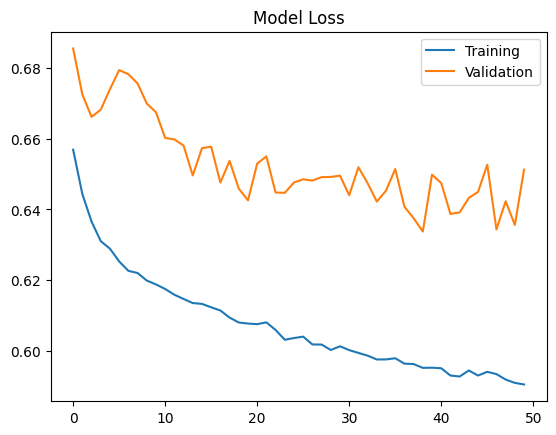

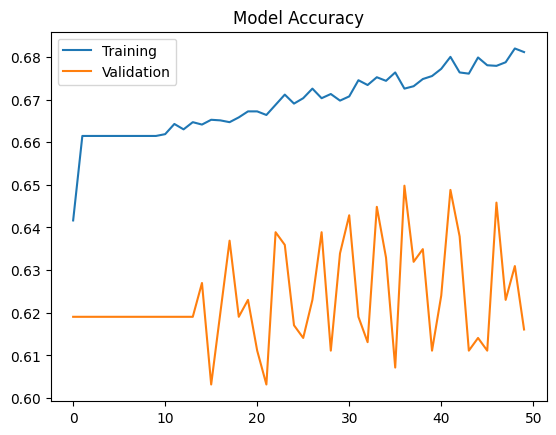

In [73]:
plt.figure()
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.title('Model Loss')

plt.figure()
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.title('Model Accuracy')

plt.show()

Transfer learning

In [75]:
base = tf.keras.applications.vgg19.VGG19(include_top=False,
                                               weights='imagenet',
                                               input_shape=(240, 240, 3),
                                               pooling='max')

tr_mod = tf.keras.models.Sequential()
tr_mod.add(base)
tr_mod.add(tf.keras.layers.Dropout(0.2))
tr_mod.add(tf.keras.layers.Dense(240, activation='relu'))
tr_mod.add(tf.keras.layers.Dense(1, activation='sigmoid'))
base.trainable=False

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [76]:
tr_mod.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 512)                 │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 240)                 │         123,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             241 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,147,745 (76.86 MB)

 Trainable params: 123,361 (481.88 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [80]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-5,
    decay_steps=100000,
    decay_rate=0.8)

In [ ]:
tr_mod.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
epoch_num = 50

history = tr_mod.fit(
    train_data,
    validation_data=test_data,
    epochs=epoch_num,
)

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 101s 825ms/step - accuracy: 0.6615 - loss: 20243380224.0000 - val_accuracy: 0.6190 - val_loss: 22779631616.0000
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 50s 877ms/step - accuracy: 0.6543 - loss: 20670230528.0000 - val_accuracy: 0.6190 - val_loss: 22779631616.0000
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 46s 808ms/step - accuracy: 0.6598 - loss: 20342376448.0000 - val_accuracy: 0.6190 - val_loss: 22779631616.0000
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 83s 821ms/step - accuracy: 0.6718 - loss: 19626008576.0000 - val_accuracy: 0.6190 - val_loss: 22779633664.0000
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 803ms/step - accuracy: 0.6619 - loss: 20216219648.0000 - val_accuracy: 0.6190 - val_loss: 22779633664.0000
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 47s 828ms/step - accuracy: 0.6555 - loss: 20601266176.0000 - val_accuracy: 0.6190 - val_loss: 22779631616.0000
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 86s 904ms/step - accuracy: 0.6689 - loss: 19799275520.0000 - val_ac

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.title('Model Loss')

plt.figure()
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.title('Model Accuracy')

plt.show()

In [ ]:
from transformers import TFViTForImageClassification

In [ ]:
base_model = TFViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k')

inputs = layers.Input(shape=(3,240,240), name='inputs', dtype='float32')

# model layer
vit = base_model.vit(pixel_values)[0]
out = layers.Dense(1, activation='sigmoid', name='outputs')(vit[:, 0, :])

# model
vit_mod = Model(inputs=inputs, outputs=out)

In [ ]:
vit_mod.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
epoch_num = 100

history = vit_mod.fit(
    train_data,
    validation_data=test_data,
    epochs=epoch_num,
)